# Problem Definition
  * **Problem Statement:** The dataset consists of Boots Online Doctor customer data over the past `two` years.
  * **Task:** Forecast customer data for the next 90 days, covering the period from `January 23, 2025`, to `April 22, 2025`.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import itertools

# Statistical tools
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Time series models
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine learning models
import xgboost as xgb

# Plotting settings
from pylab import rcParams

# Ignore warnings
warnings.filterwarnings('ignore')

# To show plots
%matplotlib inline

*   Reading the dataset into the correct datetime format.
*   Separating the training data and forecasting dataset into two separate variables.
*   Performing validation checks (column types).


In [2]:
# Load data and parse dates in DD/MM/YYYY format
sales_data = pd.read_csv(
    filepath_or_buffer='bdh_forecast_exercise.csv',
    index_col='date',
    parse_dates=['date'],
    dayfirst=True,
)

# Split the data into historical (all but last 90 days) and forecast (last 90 days) sets
sales_df, sales_forecast = sales_data[:-90], sales_data[-90:]

# Check data types
sales_df.reset_index().dtypes

,0
date,datetime64[ns]
orders,float64


As we can see, both features now have the correct data types: `float` and `datetime`.

In [3]:
sales_df.head()

,orders
date,
2023-04-24,290.0
2023-04-25,653.0
2023-04-26,727.0
2023-04-27,573.0
2023-04-28,620.0


# Data Cleaning & Validations


## Correcting index frequence to Day level

In [4]:
# Setting the frequency of the DataFrame index to daily
sales_df.index.freq = 'D'
sales_df.index

DatetimeIndex(['2023-04-24', '2023-04-25', '2023-04-26', '2023-04-27',
               '2023-04-28', '2023-04-29', '2023-04-30', '2023-05-01',
               '2023-05-02', '2023-05-03',
               ...
               '2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16',
               '2025-01-17', '2025-01-18', '2025-01-19', '2025-01-20',
               '2025-01-21', '2025-01-22'],
              dtype='datetime64[ns]', name='date', length=640, freq='D')

## Missing Values

In [5]:
# Checking for missing values in each column
sales_df.reset_index().isnull().sum()

,0
date,0
orders,0


There are no missing values present in the dataset.

## Missing Dates

In [6]:
# Generate a complete date range from the min to max date
full_date_range = pd.date_range(start=sales_df.index.min(),
                                end=sales_df.index.max(), freq='D')

# Find missing dates by comparing the full range with actual dates
missing_dates = full_date_range.difference(sales_df.index)

# Display missing dates, if any
if not missing_dates.empty:
    print("Missing dates in the dataset:")
    print(missing_dates)
else:
    print("No missing dates found in the dataset.")

No missing dates found in the dataset.


## Data Errors (Negative Values or Zero Values)

In [7]:
# Check for data errors (negative/zero values in 'orders' column)
negative_orders_count = len(sales_df[sales_df['orders'] <= 0])
print(f"Number of negative/zero 'orders' values: {negative_orders_count}")

Number of negative/zero 'orders' values: 0


# Exploratory Data Analysis

## Trend Analysis

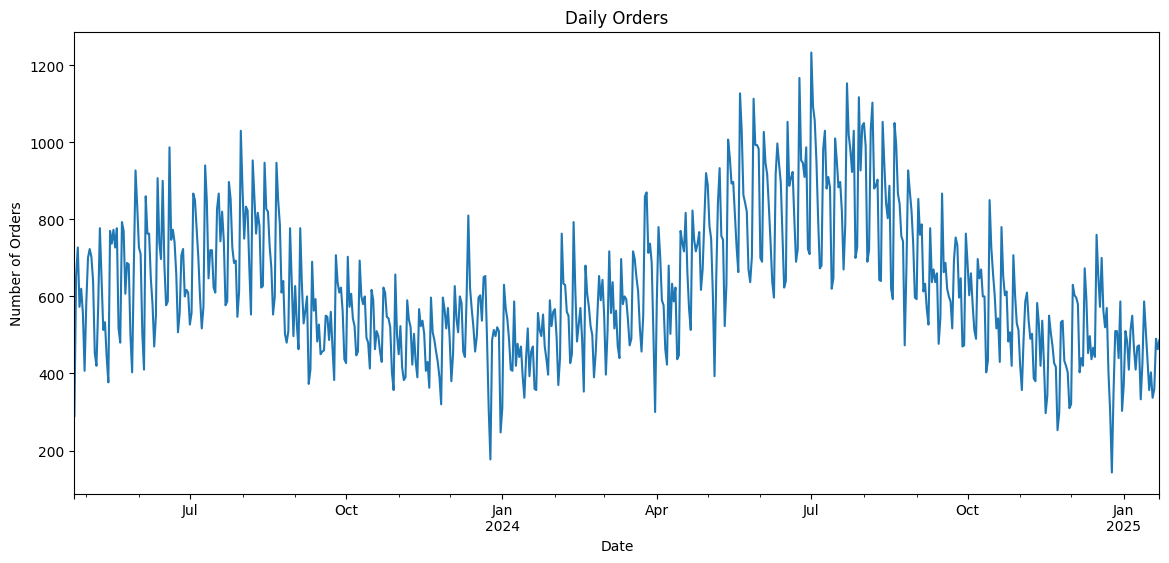

In [8]:
# Correct figure size
plt.figure(figsize=(14, 6))

# Plotting the 'orders' column with a title
sales_df["orders"].plot(title="Daily Orders")
plt.xlabel("Date")
plt.ylabel("Number of Orders")

# Display plot
plt.show()

**Observed Trends:**
*   **Summer Peak (`May–July`)**
*   **Winter Dip (`Reduced Demand`)**
*   **Lowest Point Around Late `December 2023 & 2024`**
*   **Week-to-Week Demand Shifts**
*   **Overall Yearly Pattern Is Symmetrical**
*   **Outliers are present**

## Distributions & Skewness

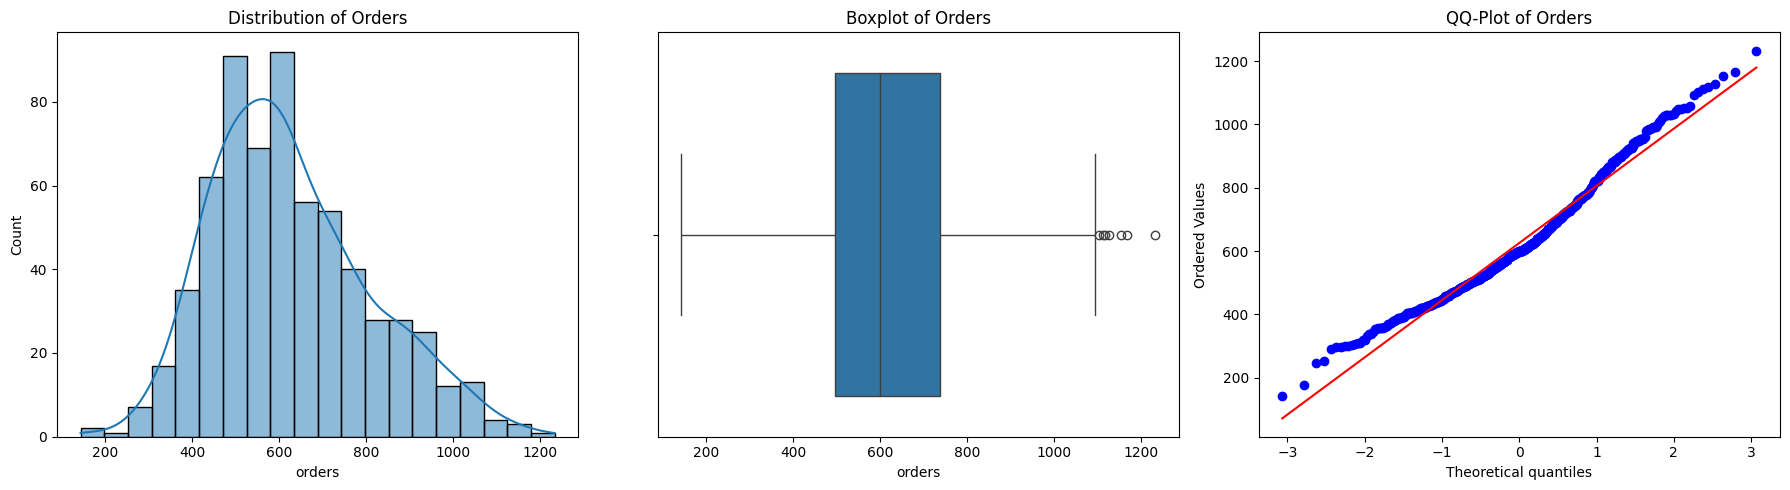

In [9]:
# Set the figure size
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histogram with KDE - To visualize the distribution and detect skewness
sns.histplot(sales_df['orders'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Orders')

# 2. Boxplot - To identify outliers and understand data spread
sns.boxplot(x=sales_df['orders'], ax=axes[1])
axes[1].set_title('Boxplot of Orders')

# 3. QQ-plot - To assess how closely the data follows a normal distribution
stats.probplot(sales_df['orders'], dist="norm", plot=axes[2])
axes[2].set_title('QQ-Plot of Orders')

# Adjust layout
plt.tight_layout()
plt.show()

* **Distribution Plot**: Slight right skew; mostly symmetric around 500–600 orders.
* **BoxPlot**: Few high-end outliers; moderate overall spread.
* **QQ-Plot**: Data is approximately normal with slight tail deviations.

In [10]:
# Calculate skewness - Measures asymmetry of the data distribution
orders_skewness = skew(sales_df['orders'])
print(f"Skewness of Orders: {orders_skewness:.4f}")

# Calculate kurtosis - Measures the "tailedness" (extremes) of the data distribution
orders_kurtosis = kurtosis(sales_df['orders'])
print(f"Kurtosis of Orders: {orders_kurtosis:.4f}")

Skewness of Orders: 0.5690
Kurtosis of Orders: -0.0098


* **Skewness**: The skewness value of 0.5825 indicates a slight positive skew, meaning the right tail of the distribution is a bit heavier.
* **Kurtosis**: The kurtosis value of -0.0098 suggests the distribution is close to normal, without heavy tails or extreme outliers.

## Seasonal-Trend-Loess (STL)

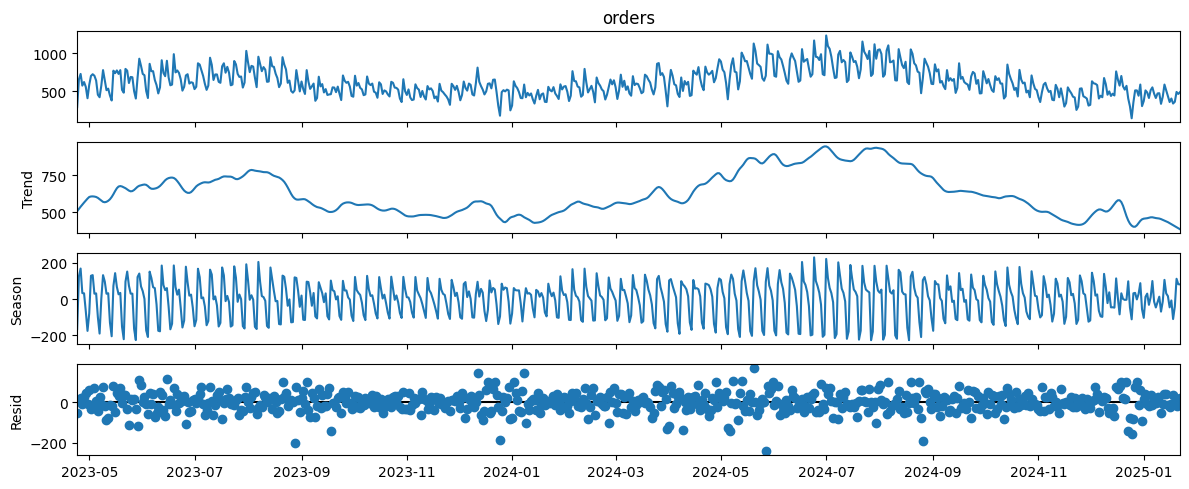

In [11]:
# Setting the default figure size for all plots
rcParams['figure.figsize'] = (12,5)

# Performing STL decomposition on the 'orders' column
stl_decompose = STL(endog=sales_df["orders"]).fit()

# decomposition = seasonal_decompose(sales_df["orders"], model="additive", period=7)
# Plotting the STL decomposition
stl_decompose.plot()

# Display plot
plt.show()

**Trend:**

  1.   **Summer Peak (`May–July`)**:
    *   **Insight**: The spike around `May–July` could be linked to increased demand for sales.
    *   **Assumptions**: Likely due to Peak Travel Season, School Summer Holidays, Seasonal conditions like hay fever.
    *   *Tip: Boots could run `targeted promotions` to further capitalise on this natural demand peak*.

  2.   **Winter Dip (`Reduced Demand`)**:
    *   **Insight**: There’s a noticeable, repeatable drop in orders between late `November` and early `January`.
    *   **Assumptions**: Likely due to Reduced customer engagement during the festive season, Non-urgent needs postponed until the new year.
    *   *Tip: Launch `New Year Health Kick` promotions in early January to reactivate users and recover volume faster*.

  3. **Lowest Point Around Late `December 2023 & 2024`**:
    *   **Insight**: Orders briefly fall below `200/day` during the final week of `December` — an extreme dip.
    *   **Assumptions**: Likely due to Christmas and New Year holidays, Reduced operations/fulfilment, Minimal user intent during that week.
  4. **Parameters for SARIMAX model:**
    *   Based on the trend and strong weekly seasonality, set differencing parameters as `d=1`, `D=1`, and season length `s=7`.

**Seasonal:**

  1. **Overall Yearly Pattern Is Symmetrical**:
    *   **Insight**: The curve shows a repeating rise (spring), peak (summer), and fall (autumn).

  2. **Week-to-Week Demand Shifts**:
    *   **Insight**: A consistent weekly demand cycle is visible across the year, with high orders on `Mondays–Tuesdays`, and dips on weekends.

**Residuals:**

*   **Insight**: Residuals mostly stay within ±200, which is acceptable.

In [12]:
d = 1
D = 1
s = 7

*   `d=1` is used because the trend shows a gradual upward and downward movement over time — differencing once removes this trend and makes the data stationary.
*   `D=1` is applied because the seasonal component shows a repeating weekly pattern — seasonal differencing helps remove that weekly cycle.
*   `s=7` is chosen because the seasonality clearly repeats every 7 days.

## Stationarity
Let's analyse the stationarity of the orders.

In [13]:
def adf_test(series, print_res=True):
    # Running the Augmented Dickey-Fuller test
    result = adfuller(series)

    # Extracting statistics
    adf_stats = 'ADF Statistics: {}'.format(result[0])
    adf_pvalue = 'p-value: {}'.format(result[1])

    # Interpretation based on p-value
    if result[1] <= 0.05:
        results = "Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary."
    else:
        results = "Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary."

    # Printing results if requested
    if print_res:
        print(adf_stats)
        print(adf_pvalue)
        print(results)

    # Returning True if stationary, False otherwise
    return result[1] <= 0.05

In [14]:
adf_test(sales_df["orders"]);

ADF Statistics: -1.158863342144646
p-value: 0.6910367695276936
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary.


As we can see that our original orders is not stationary.

# Data Preprocessing

## Integrated (Difference)

In [15]:
def integrated(series, shift_num=1):
    # Returns a tuple of (description, differenced 'orders' column by shift_num)
    return (f'Orders {shift_num} Difference', series['orders'] - series['orders'].shift(shift_num))

Shifting by 7 values, based on the seasonality trend, we observed that the pattern repeats weekly.

In [16]:
# Generate integrated (differenced) values with 7-lag shift and add as a new column
column_name, values = integrated(sales_df, shift_num=7)
sales_df[column_name] = values
sales_df.head()

,orders,Orders 7 Difference
date,,
2023-04-24,290.0,NaN
2023-04-25,653.0,NaN
2023-04-26,727.0,NaN
2023-04-27,573.0,NaN
2023-04-28,620.0,NaN


## Correlation
Let's measures direct correlation between the series and its lags.

### Partial Autocorrelations (PACF)
To identify p & P values for AutoRegression (AR).

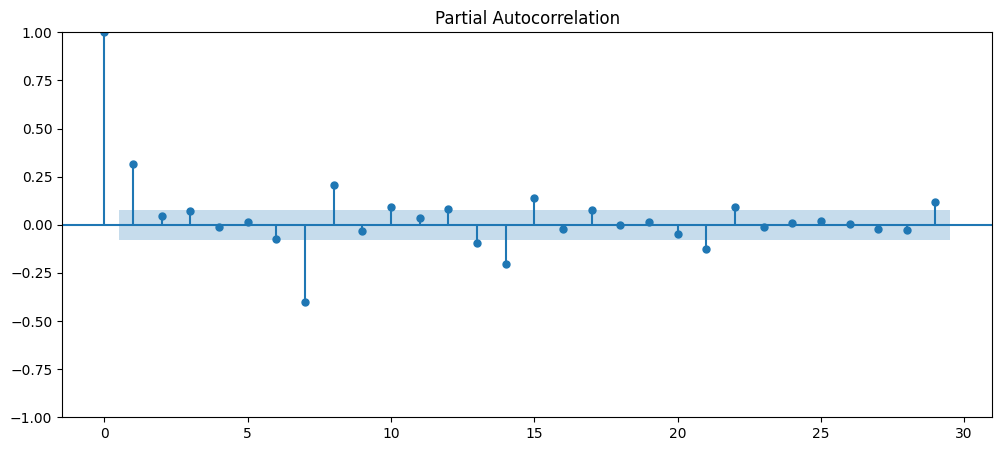

In [17]:
# Plot Partial Autocorrelation Function (PACF) to identify significant lags for AR terms
pacf = plot_pacf(sales_df["Orders 7 Difference"].dropna())

*   Let's experiment with p values: 1, and 7, based on PACF spikes observed.
*   Although a strong seasonal spike appears at lag 7, suggesting P = 1, I included both P = 0 and P = 1 in the grid search to allow model selection between a simpler and a seasonal AR structure.

In [18]:
p_values = [1, 7]
P_values = [0, 1]

### Autocorrelations (ACF)
To identify q & Q values for Moving Average (MA).

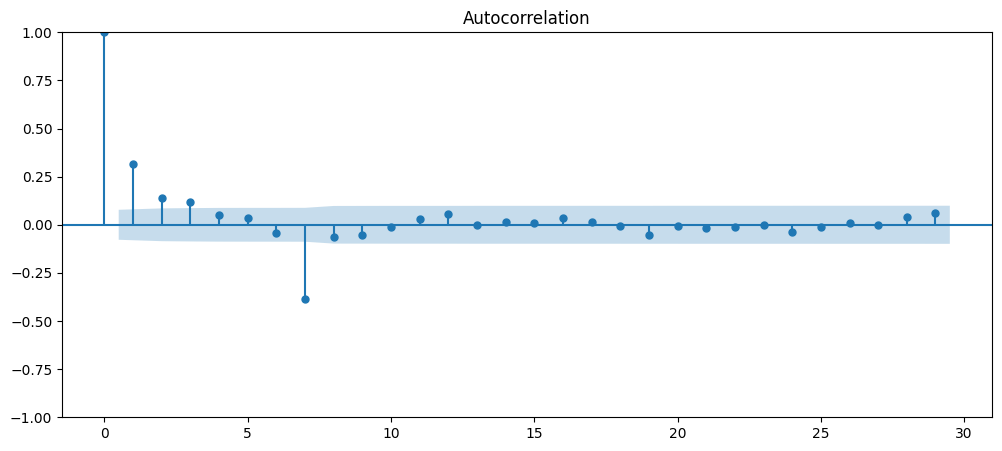

In [19]:
# Plot Autocorrelation Function (ACF) to identify significant lags for MA terms
acf = plot_acf(sales_df["Orders 7 Difference"].dropna())

*   Let's experiment with q values: 1, and 2, based on the ACF plot.
*   Although the strong spike at lag 7 suggests Q = 1, both Q = 0 and Q = 1 are included in the grid search to evaluate if seasonal moving average components improve model performance.

In [20]:
q_values = [1, 2]
Q_values = [0, 1]

Drop stationarity column

In [21]:
# Drop the temporary differenced column used for stationarity
sales_df.drop([column_name], axis=1, inplace=True)

## Feature Engineering

In [22]:
# --- Basic Feature Engineering ---
def feature_engineer(df):

    # Create date-based features
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(float)
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['is_month_start'] = df.index.is_month_start.astype(float)
    df['is_month_end'] = df.index.is_month_end.astype(float)
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    # One-hot encode categorical date features
    dow_dummies = pd.get_dummies(df['dayofweek'], prefix='dow', drop_first=True).astype(float)
    month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True).astype(float)
    quarter_dummies = pd.get_dummies(df['quarter'], prefix='quarter', drop_first=True).astype(float)

    # Merge dummy features into main DataFrame
    df = pd.concat([df, dow_dummies, month_dummies, quarter_dummies], axis=1)
    df.drop(columns=['dayofweek', 'month', 'quarter'], inplace=True)

    return df.columns, df

* **Date-based Features**: Extracted features such as day of week, month, day of month, quarter, year, and flags for month start/end and weekend.
* **One-Hot Encoded Features**: Created dummy variables for day of week, month, and quarter to capture categorical time patterns.

## Tranformation
Performing log transformation to reduce the identified positive skewness.

In [23]:
def transform(columns, df):
  # Log-transform
  return np.log1p(df[columns])

## Feature Scaling
This is only done for XGBoost to improve model convergence and performance.

In [24]:
def scale_features():
  # Scale features
  return StandardScaler()
scalar = scale_features()

# Building Model

## Cross Validation Split

In [25]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=15)

## SARIMAX Model

### Build Model

In [26]:
# Perform SARIMAX cross-validation with grid search.
def sarimax_cross_validation(X, y, tscv, param_grid, d, D, s):
  # --- Start Time for SARIMAX ---
  start_time_sarimax = time.time()

  # Initialize tracking for best model
  best_score = float('inf')
  best_params = None
  best_model_result = None
  best_forecasts = None

  # --- Grid Search with Cross-Validation ---
  for p, q, P, Q in param_grid:
      # Auto-skip invalid model settings
      if (q == s) and (Q != 0):
          continue
      if (p == s) and (P != 0):
          continue

      current_mae_list = []
      current_rmse_list = []
      current_r2_list = []
      all_actuals = []
      all_predictions = []

      try:
          for train_idx, test_idx in tscv.split(X):
              # Train-test split
              X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
              y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

              # Define SARIMAX model
              model = SARIMAX(y_train,
                              exog=X_train,
                              order=(p, d, q),
                              seasonal_order=(P, D, Q, s),
                              enforce_stationarity=False,
                              enforce_invertibility=False)

              model_fit = model.fit(disp=False)

              # Predict
              forecast = model_fit.get_prediction(start=y_test.index[0], end=y_test.index[-1], exog=X_test)
              predicted = forecast.predicted_mean

              # Metrics
              mae = mean_absolute_error(y_test, predicted)
              rmse = np.sqrt(mean_squared_error(y_test, predicted))
              r2 = r2_score(y_test, predicted)

              current_mae_list.append(mae)
              current_rmse_list.append(rmse)
              current_r2_list.append(r2)

              # Save predictions
              all_actuals.append(y_test)
              all_predictions.append(predicted)

          # Average scores
          avg_mae = np.mean(current_mae_list)
          avg_rmse = np.mean(current_rmse_list)
          avg_r2 = np.mean(current_r2_list)

          # Only print and update if new best model
          if avg_rmse < best_score:
              best_score = avg_rmse
              best_params = (p, d, q, P, D, Q, s)
              best_model_result = (current_mae_list, current_rmse_list, current_r2_list)
              best_forecasts = (all_actuals, all_predictions)

              # --- Refitting the best model on entire data (for production use) ---
              best_model = SARIMAX(
                  y,
                  exog=X,
                  order=(p, d, q),
                  seasonal_order=(P, D, Q, s),
                  enforce_stationarity=False,
                  enforce_invertibility=False
              ).fit(disp=False)

              # Print new best result
              print(f"New Best Model -> (p,d,q)=({p},{d},{q}), (P,D,Q,s)=({P},{D},{Q},{s})")
              print(f"Average RMSE across folds: {avg_rmse:.2f}")
              print(f"Best Fold MAE: {np.min(current_mae_list):.2f}")
              print(f"Best Fold RMSE: {np.min(current_rmse_list):.2f}")
              print(f"Best Fold R2: {np.max(current_r2_list):.4f}\n")

      except Exception as e:
          continue

  # --- End Time for SARIMAX ---
  end_time_sarimax = time.time()
  sarimax_time_taken = end_time_sarimax - start_time_sarimax

  # --- Return the results ---
  return (
      best_params, # best_params
      best_score, # best_score
      sarimax_time_taken, # time_taken
      best_forecasts, # best_forecasts
      best_model_result, # metrics
      best_model # Fitted best model for production use
  )

* **Grid Search**: Iterates over combinations of (p, d, q) and (P, D, Q, s) parameters to `find the best` SARIMAX model.
* **Cross-Validation**: Evaluates model performance on each fold using TimeSeriesSplit to avoid `data leakage`.
* **Model Evaluation**: Calculates `MAE`, `RMSE`, and `R²` for each fold and averages them to select the best model.
* **Model Selection**: Tracks and updates the best model based on the lowest average RMSE across all folds.
* **Final Model**: After finding the best parameters, refits the SARIMAX model on the entire dataset for `production use`.
* **Output**: Returns the best parameters, best score, time taken, cross-validation forecasts, evaluation metrics, and the final fitted model.

#### Train (No Transformation)

In [27]:
# Apply feature engineering
columns, sales_dp = feature_engineer(sales_df)

# Define features and target
X = sales_dp.drop(columns=['orders'])
y = sales_dp['orders']

# Build all combinations
param_grid = list(itertools.product(p_values, q_values, P_values, Q_values))

In [28]:
(best_params_untransformed, best_score_untransformed, sarimax_time_taken_untransformed,
 best_forecasts_untransformed, best_model_result_untransformed, best_model_untransformed) = sarimax_cross_validation(X, y, tscv, param_grid, d=d, D=D, s=s)

New Best Model -> (p,d,q)=(1,1,1), (P,D,Q,s)=(0,1,0,7)
Average RMSE across folds: 153.04
Best Fold MAE: 51.26
Best Fold RMSE: 63.92
Best Fold R2: 0.6010

New Best Model -> (p,d,q)=(1,1,1), (P,D,Q,s)=(0,1,1,7)
Average RMSE across folds: 125.37
Best Fold MAE: 46.88
Best Fold RMSE: 57.41
Best Fold R2: 0.7400

New Best Model -> (p,d,q)=(1,1,2), (P,D,Q,s)=(0,1,1,7)
Average RMSE across folds: 121.90
Best Fold MAE: 46.87
Best Fold RMSE: 58.80
Best Fold R2: 0.7066



#### Train (Transformated)

In [29]:
# Apply feature engineering
columns, sales_dp = feature_engineer(sales_df)

# Transform with log
temp_sale_df = transform(['orders'], sales_dp)

# Copy original engineered features (excluding 'orders') into transformed DataFrame
cols_copy = sales_dp.drop('orders', axis=1).columns
temp_sale_df[cols_copy] = sales_dp[cols_copy]

# Define features and target
X = temp_sale_df.drop(columns=['orders'])
y = temp_sale_df['orders']

# Build all combinations
param_grid = list(itertools.product(p_values, q_values, P_values, Q_values))

In [30]:
(best_params_log, best_score_log, sarimax_time_taken_log,
 best_forecasts_log, best_model_result_log, best_model_log) = sarimax_cross_validation(X, y, tscv, param_grid, d=d, D=D, s=s)

New Best Model -> (p,d,q)=(1,1,1), (P,D,Q,s)=(0,1,0,7)
Average RMSE across folds: 0.25
Best Fold MAE: 0.11
Best Fold RMSE: 0.13
Best Fold R2: 0.3830

New Best Model -> (p,d,q)=(1,1,1), (P,D,Q,s)=(0,1,1,7)
Average RMSE across folds: 0.22
Best Fold MAE: 0.09
Best Fold RMSE: 0.11
Best Fold R2: 0.6462

New Best Model -> (p,d,q)=(7,1,1), (P,D,Q,s)=(0,1,1,7)
Average RMSE across folds: 0.22
Best Fold MAE: 0.09
Best Fold RMSE: 0.11
Best Fold R2: 0.6258

New Best Model -> (p,d,q)=(7,1,2), (P,D,Q,s)=(0,1,1,7)
Average RMSE across folds: 0.22
Best Fold MAE: 0.09
Best Fold RMSE: 0.12
Best Fold R2: 0.5065



### Model Evaluation

In [31]:
# Summarizes and plots the best SARIMAX model results from separate variables.
def plot_results(best_params, best_score, best_forecasts, best_model_result, title_suffix=''):
  # --- Best Model Summary ---
  if best_params is not None:
      print("\n=== Best Model Found ===")
      print(f"Best Params: (p,d,q)=({best_params[0]},{best_params[1]},{best_params[2]}), (P,D,Q,s)=({best_params[3]},{best_params[4]},{best_params[5]},{best_params[6]})")
      print(f"Average RMSE across folds: {best_score:.2f}")
      print(f"Best Fold MAE: {np.min(best_model_result[0]):.2f}")
      print(f"Best Fold RMSE: {np.min(best_model_result[1]):.2f}")
      print(f"Best Fold R2: {np.max(best_model_result[2]):.4f}")

      # --- Plotting best fold ---
      all_actuals_concat = pd.concat(best_forecasts[0])
      all_predictions_concat = pd.concat(best_forecasts[1])

      plt.figure(figsize=(16,8))
      plt.plot(all_actuals_concat.index, all_actuals_concat.values, label='Actual Orders', color='blue')
      plt.plot(all_predictions_concat.index, all_predictions_concat.values, label='SARIMAX Predicted Orders', linestyle='--', color='green')
      plt.title(f'Best SARIMAX Forecast {title_suffix}\n(p,d,q)=({best_params[0]},{best_params[1]},{best_params[2]}), (P,D,Q,s)=({best_params[3]},{best_params[4]},{best_params[5]},{best_params[6]})')
      plt.xlabel('Date')
      plt.ylabel('Orders')
      plt.legend()
      plt.grid(True)
      plt.show()
  else:
      print("No model converged successfully.")

#### Model evalutaion for Untransformed (Original) data.


=== Best Model Found ===
Best Params: (p,d,q)=(1,1,2), (P,D,Q,s)=(0,1,1,7)
Average RMSE across folds: 121.90
Best Fold MAE: 46.87
Best Fold RMSE: 58.80
Best Fold R2: 0.7066


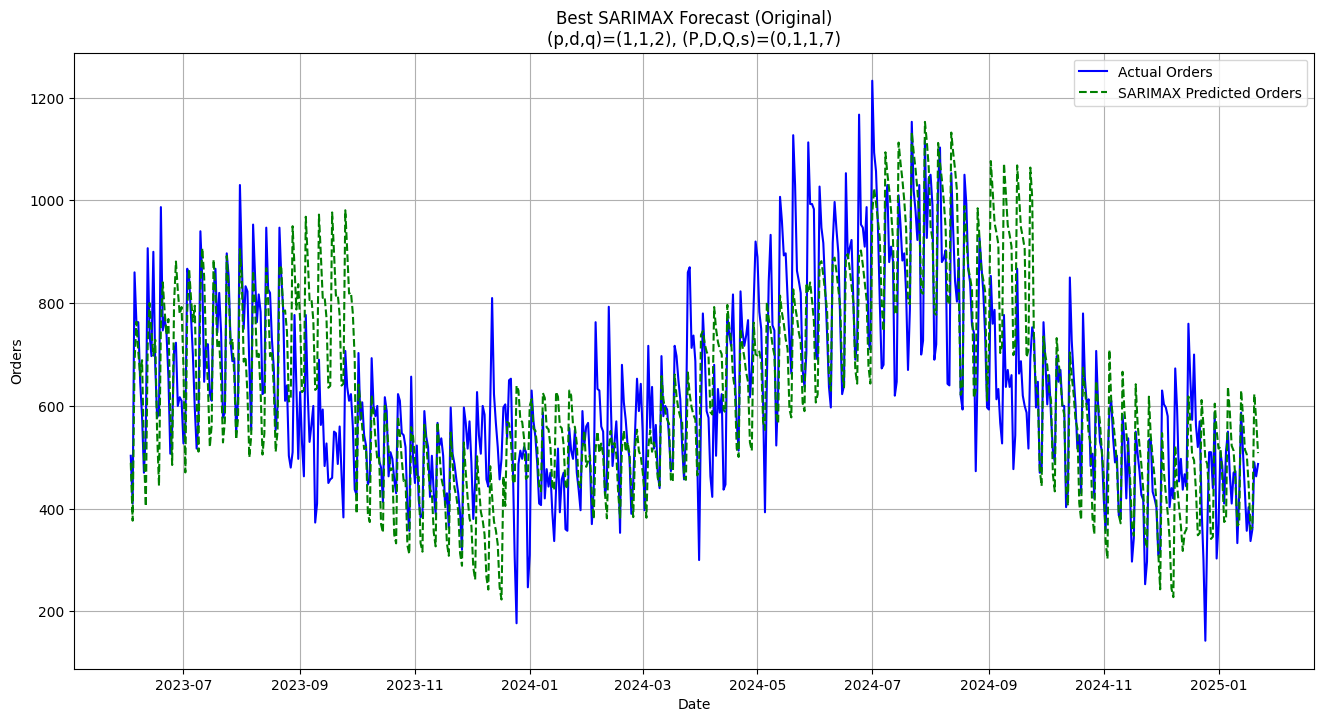

In [32]:
# Plot and summarize SARIMAX best model results for original (untransformed) data
plot_results(best_params_untransformed, best_score_untransformed,
             best_forecasts_untransformed, best_model_result_untransformed,
             title_suffix='(Original)')

*   **Prediction Alignment**: The `green dashed line` (SARIMAX predicted orders) closely follows the `blue line` (actual orders) throughout most periods.
*   **Seasonality Capture**: Clear `weekly ups and downs` are mirrored accurately by the model.
*   **Under/Over Estimation**: Minor `under-predictions` near sales peaks observed. However, overall prediction error is small, and general alignment is strong.

#### Model evalutaion for log-transformed data.


=== Best Model Found ===
Best Params: (p,d,q)=(7,1,2), (P,D,Q,s)=(0,1,1,7)
Average RMSE across folds: 0.22
Best Fold MAE: 0.09
Best Fold RMSE: 0.12
Best Fold R2: 0.5065


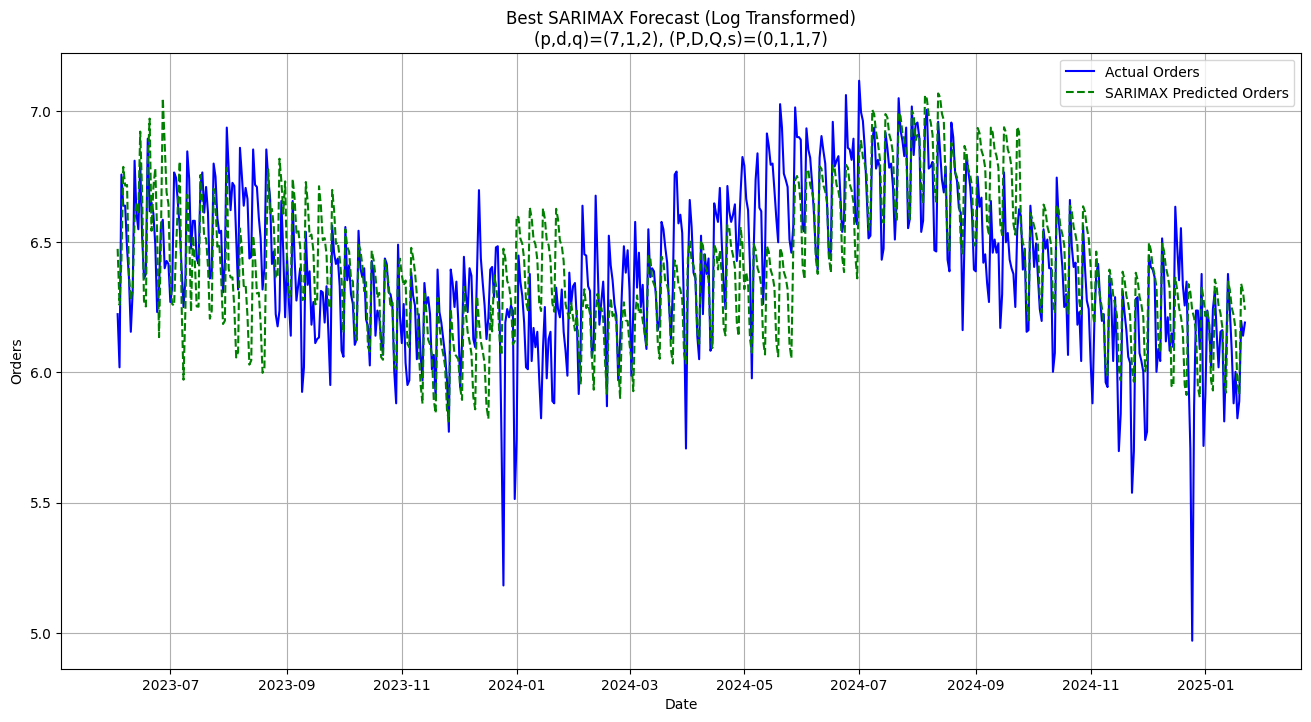

In [33]:
# Plot and summarize SARIMAX best model results for Log Transformed data
plot_results(best_params_log, best_score_log,
             best_forecasts_log, best_model_result_log,
             title_suffix='(Log Transformed)')

*   **Prediction Alignment**: The model captures overall patterns and trends but tends to slightly smooth sharp peaks and dips.
*   **Trend Behavior**: `Log transformation` made the time series more stable and reduced variance, helping the model generalize better.
*   **Error Behavior**: `Residual errors` are reduced compared to non-log model, leading to more  consistent performance across different periods.


## XGBoost Regression

### Build Model

In [34]:
# Perform XGBoost cross-validation.
def xgboost_cross_validation(X_scaled, y, tscv):
  # --- Start timer for XGBoost training ---
  start_time_xgb = time.time()

  # Initialize lists to store fold-wise evaluation metrics
  mae_list = []
  rmse_list = []
  r2_list = []
  fold_predictions = {}

  # Start cross-validation
  fold = 1
  best_rmse = float('inf')
  best_train_idx = None
  best_test_idx = None

  for train_idx, test_idx in tscv.split(X_scaled):
      # Split data into training and testing sets
      X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
      y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

      # Initialize XGBoost Regressor with specified hyperparameters
      model = xgb.XGBRegressor(
          objective='reg:squarederror',
          n_estimators=500,
          learning_rate=0.05,
          max_depth=7,
          subsample=0.8,
          colsample_bytree=0.8,
          random_state=42
      )

      # Train the model
      model.fit(X_train, y_train)

      # Predict on the test set
      predicted = model.predict(X_test)

      # Calculate evaluation metrics
      mae = mean_absolute_error(y_test, predicted)
      rmse = np.sqrt(mean_squared_error(y_test, predicted))
      r2 = r2_score(y_test, predicted)

      # Print fold results
      print(f"Fold {fold} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

      # Save actual vs predicted results and RMSE for the fold
      fold_predictions[fold] = {
          'actual': y_test,
          'predicted': pd.Series(predicted, index=y_test.index),
          'rmse': rmse,
          'mae': mae,
          'r2': r2
      }

      # Store evaluation metrics
      mae_list.append(mae)
      rmse_list.append(rmse)
      r2_list.append(r2)

      # Track best fold based on RMSE
      if rmse < best_rmse:
          best_rmse = rmse
          best_train_idx = train_idx
          best_test_idx = test_idx

      fold += 1

  # --- End timer for XGBoost training ---
  end_time_xgb = time.time()
  xgb_time_taken = end_time_xgb - start_time_xgb

  # --- Retrain on best fold's training data ---
  X_train_best = X_scaled[best_train_idx]
  y_train_best = y.iloc[best_train_idx]

  best_model = xgb.XGBRegressor(
      objective='reg:squarederror',
      n_estimators=500,
      learning_rate=0.05,
      max_depth=7,
      subsample=0.8,
      colsample_bytree=0.8,
      random_state=42
  )

  best_model.fit(X_train_best, y_train_best)

  # --- Return the results ---
  return (
      mae_list, # mae list
      rmse_list, # rmse list
      r2_list, # r2 list
      xgb_time_taken, # xgb time taken
      fold_predictions, # fold predictions
      best_model # Fitted best model for production use
  )

*   **Cross-Validation**: Splits the time series data using TimeSeriesSplit to preserve the temporal order without `data leakage`.
*   **Model Training**: Trains an `XGBoost regressor` on each fold with predefined hyperparameters.
*   **Model Evaluation**: Calculates `MAE`, `RMSE`, and `R²` for each fold to measure prediction accuracy.
*   **Best Fold Selection**: Identifies the fold with the lowest RMSE as the best split for final model training.
*   **Retrain Best Model**: Retrains XGBoost on the best training fold to produce the final model ready for `production use`.
*   **Output**: Returns fold-wise metrics (`MAE`, `RMSE`, `R²`), total training time, fold predictions, and the best fitted XGBoost model.

#### Prepare the data

In [35]:
# Apply feature engineering
columns, sales_dp = feature_engineer(sales_df)

# Define features and target
X = sales_dp.drop(columns=['orders'])
y = sales_dp['orders']

# Feature Scaling
X_scaled = scalar.fit_transform(X)

#### Train XGBoost Model

In [36]:
(mae_list_xg, rmse_list_xg, r2_list_xg, xgb_time_taken_xg,
 fold_predictions_xg, best_model_xg) = xgboost_cross_validation(X_scaled, y, tscv)

Fold 1 -> MAE: 100.15, RMSE: 135.46, R2: 0.05
Fold 2 -> MAE: 90.83, RMSE: 111.79, R2: 0.19
Fold 3 -> MAE: 170.37, RMSE: 196.51, R2: -2.14
Fold 4 -> MAE: 145.02, RMSE: 167.22, R2: -2.76
Fold 5 -> MAE: 47.99, RMSE: 62.05, R2: 0.54
Fold 6 -> MAE: 149.73, RMSE: 183.52, R2: -2.29
Fold 7 -> MAE: 85.34, RMSE: 106.99, R2: -0.18
Fold 8 -> MAE: 129.88, RMSE: 160.43, R2: -0.60
Fold 9 -> MAE: 195.42, RMSE: 217.05, R2: -1.15
Fold 10 -> MAE: 169.27, RMSE: 203.81, R2: -0.63
Fold 11 -> MAE: 84.50, RMSE: 105.52, R2: 0.49
Fold 12 -> MAE: 63.92, RMSE: 85.30, R2: 0.62
Fold 13 -> MAE: 89.82, RMSE: 111.07, R2: 0.05
Fold 14 -> MAE: 75.30, RMSE: 92.47, R2: 0.18
Fold 15 -> MAE: 64.96, RMSE: 82.86, R2: 0.47


### Model Evaluation


=== Cross-Validation Average Scores ===
Avg MAE: 110.83
Avg RMSE: 134.80
Avg R2: -0.48

Best Fold: 5 with RMSE: 62.05 MAE: 47.99 R2_score: 0.54


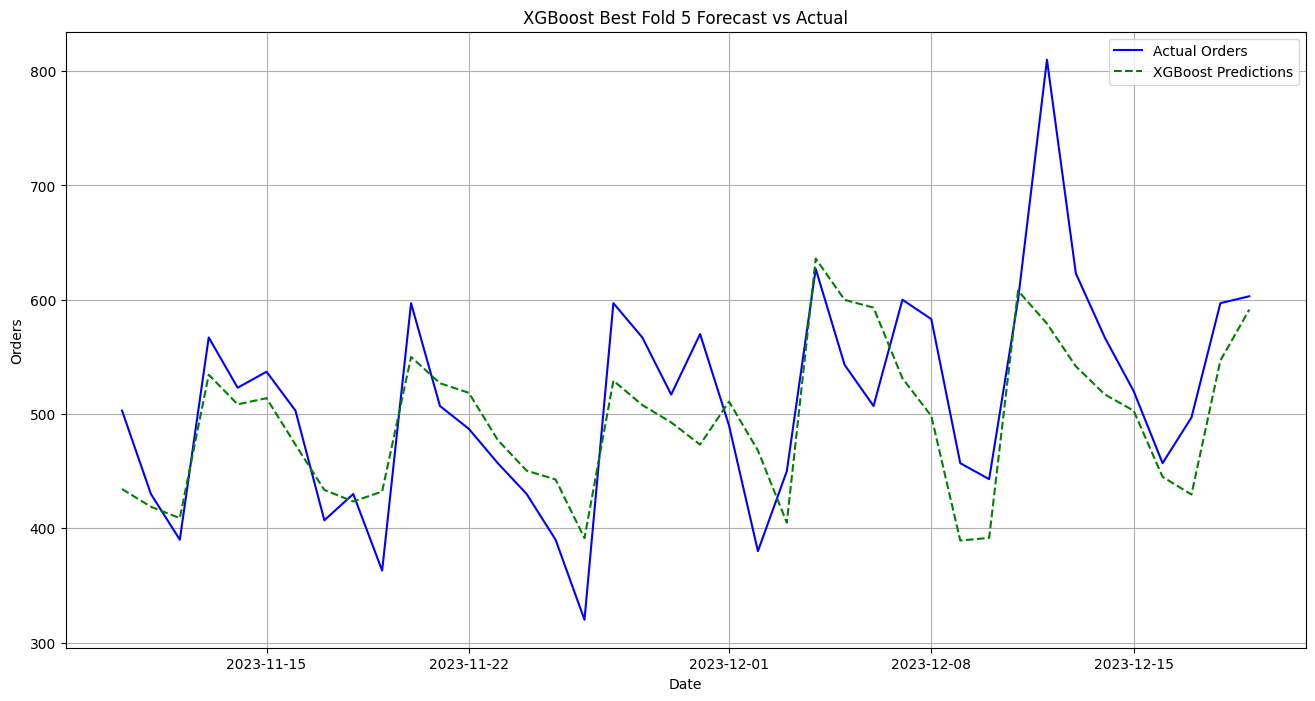

In [37]:
# Average performance
print("\n=== Cross-Validation Average Scores ===")
print(f"Avg MAE: {np.mean(mae_list_xg):.2f}")
print(f"Avg RMSE: {np.mean(rmse_list_xg):.2f}")
print(f"Avg R2: {np.mean(r2_list_xg):.2f}")

# Find best fold
best_fold = min(fold_predictions_xg, key=lambda k: fold_predictions_xg[k]['rmse'])
print_best_res = f"""\nBest Fold: {best_fold} with RMSE: {fold_predictions_xg[best_fold]['rmse']:.2f} MAE: {fold_predictions_xg[best_fold]['mae']:.2f} R2_score: {fold_predictions_xg[best_fold]['r2']:.2f}"""

print(print_best_res)

# Plot Best Fold
plt.figure(figsize=(16, 8))
plt.plot(fold_predictions_xg[best_fold]['actual'].index, fold_predictions_xg[best_fold]['actual'].values, label='Actual Orders', color='blue')
plt.plot(fold_predictions_xg[best_fold]['predicted'].index, fold_predictions_xg[best_fold]['predicted'].values, label='XGBoost Predictions', linestyle='--', color='green')
plt.title(f'XGBoost Best Fold {best_fold} Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.show()

*   **Overall Pattern**: XGBoost model captures the general trend and seasonality of the actual orders reasonably well.
*   **Undershooting Peaks**: At high spikes (e.g., around December 7 and December 12), XGBoost underpredicts the actual order values, meaning it struggles slightly during sharp demand surges.
*   **Lagging Sharp Changes**: For sudden jumps and falls, the model reacts slightly slower, smoothing out the extreme fluctuations compared to actual data.

## Best Model

XGBoost vs SARIMAX

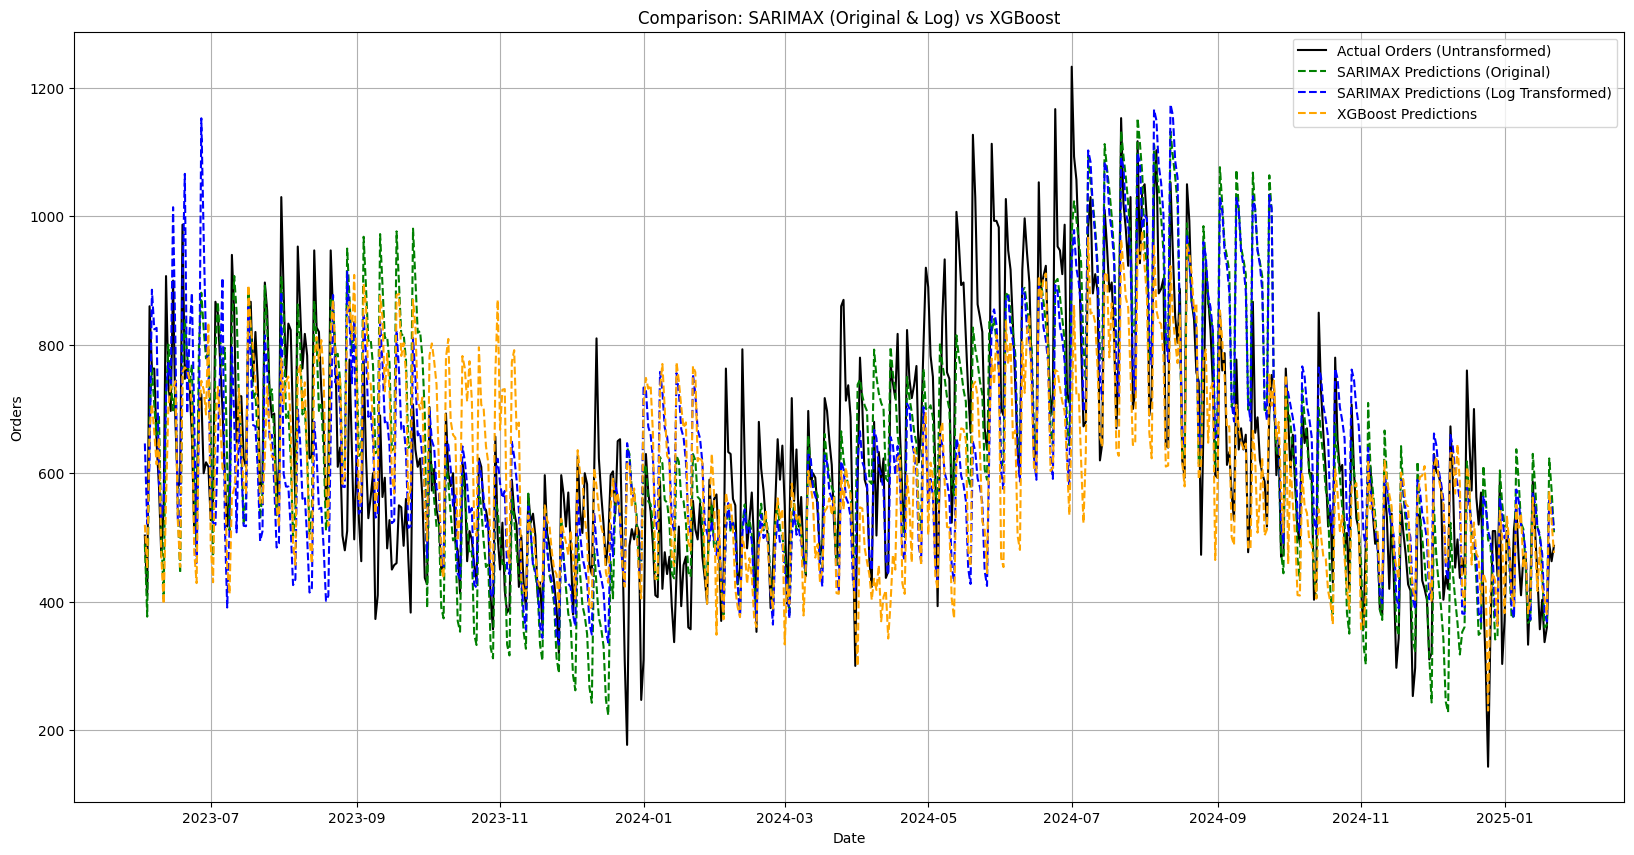

In [38]:
# --- Prepare SARIMAX predictions (untransformed) ---
sarimax_actuals_untransformed = pd.concat(best_forecasts_untransformed[0])
sarimax_predictions_untransformed = pd.concat(best_forecasts_untransformed[1])

# --- Prepare SARIMAX predictions (log-transformed and inverse transform) ---
sarimax_actuals_log = np.expm1(pd.concat(best_forecasts_log[0]))
sarimax_predictions_log = np.expm1(pd.concat(best_forecasts_log[1]))

# --- Prepare XGBoost predictions ---
xgboost_actuals = pd.concat([fold_predictions_xg[fold]['actual'] for fold in fold_predictions_xg])
xgboost_predictions = pd.concat([fold_predictions_xg[fold]['predicted'] for fold in fold_predictions_xg])

# --- Sort indexes ---
sarimax_actuals_untransformed = sarimax_actuals_untransformed.sort_index()
sarimax_predictions_untransformed = sarimax_predictions_untransformed.sort_index()
sarimax_actuals_log = sarimax_actuals_log.sort_index()
sarimax_predictions_log = sarimax_predictions_log.sort_index()
xgboost_actuals = xgboost_actuals.sort_index()
xgboost_predictions = xgboost_predictions.sort_index()

# --- Plot forecasts ---
plt.figure(figsize=(20, 10))
plt.plot(sarimax_actuals_untransformed.index, sarimax_actuals_untransformed.values, label='Actual Orders (Untransformed)', color='black')
plt.plot(sarimax_predictions_untransformed.index, sarimax_predictions_untransformed.values, label='SARIMAX Predictions (Original)', linestyle='--', color='green')
plt.plot(sarimax_predictions_log.index, sarimax_predictions_log.values, label='SARIMAX Predictions (Log Transformed)', linestyle='--', color='blue')
plt.plot(xgboost_predictions.index, xgboost_predictions.values, label='XGBoost Predictions', linestyle='--', color='orange')
plt.title('Comparison: SARIMAX (Original & Log) vs XGBoost')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.show()

*    **SARIMAX Models (Original and Log Transformed)**: Both SARIMAX models (green and blue dashed lines) closely follow the seasonality and trend of actual orders (black line), especially during regular weekly patterns. Log transformation slightly improves stability but struggles with capturing extreme peaks.
*    **XGBoost Model**: The XGBoost model (orange dashed line) captures the general trend but smooths out sharp spikes and dips more aggressively compared to SARIMAX, leading to slight underfitting during highly volatile periods.
*    **Overall Performance**: SARIMAX models outperform XGBoost in peak and seasonal accuracy, but XGBoost remains competitive in maintaining overall trend stability with lower sensitivity to noise.


### Model Comparision with (Actual Mean & Time taken)

In [39]:
# --- Calculate Metrics ---

# Mean of actual orders
actual_mean = sales_df['orders'].mean()

# SARIMAX (Untransformed)
sarimax_mae_untransformed = mean_absolute_error(sarimax_actuals_untransformed, sarimax_predictions_untransformed)
sarimax_rmse_untransformed = np.sqrt(mean_squared_error(sarimax_actuals_untransformed, sarimax_predictions_untransformed))

# SARIMAX (Log-transformed and inverse)
sarimax_mae_log = mean_absolute_error(sarimax_actuals_log, sarimax_predictions_log)
sarimax_rmse_log = np.sqrt(mean_squared_error(sarimax_actuals_log, sarimax_predictions_log))

# XGBoost
xgboost_mae = mean_absolute_error(xgboost_actuals, xgboost_predictions)
xgboost_rmse = np.sqrt(mean_squared_error(xgboost_actuals, xgboost_predictions))

# --- Percentage Errors ---
sarimax_mae_pct_untransformed = (sarimax_mae_untransformed / actual_mean) * 100
sarimax_rmse_pct_untransformed = (sarimax_rmse_untransformed / actual_mean) * 100

sarimax_mae_pct_log = (sarimax_mae_log / actual_mean) * 100
sarimax_rmse_pct_log = (sarimax_rmse_log / actual_mean) * 100

xgboost_mae_pct = (xgboost_mae / actual_mean) * 100
xgboost_rmse_pct = (xgboost_rmse / actual_mean) * 100

# --- Print Comparison Results ---

print("\n=== Final Model Comparison ===")
print(f"Mean of Actual Orders: {actual_mean:.2f}\n")

# --- SARIMAX (Untransformed) ---
print("SARIMAX (Untransformed) Results:")
print(f" - Final MAE on full data: {sarimax_mae_untransformed:.2f} ({sarimax_mae_pct_untransformed:.2f}% Error Rate)")
print(f" - Final RMSE on full data: {sarimax_rmse_untransformed:.2f} ({sarimax_rmse_pct_untransformed:.2f}% Error Rate)")
print(f" - Total Time Taken: {sarimax_time_taken_untransformed:.2f} seconds")
print(f" - Best Params: (p,d,q)=({best_params_untransformed[0]},{best_params_untransformed[1]},{best_params_untransformed[2]}), "
      f"(P,D,Q,s)=({best_params_untransformed[3]},{best_params_untransformed[4]},{best_params_untransformed[5]},{best_params_untransformed[6]})")
print(f" - Best CV Average RMSE: {best_score_untransformed:.4f}")
print(f" - Best CV Average MAE: {np.mean(best_model_result_untransformed[0]):.4f}")
print(f" - Best CV Average R2: {np.mean(best_model_result_untransformed[2]):.4f}\n")

# --- SARIMAX (Log Transformed) ---
print("SARIMAX (Log-Transformed) Results:")
print(f" - Final MAE on full data: {sarimax_mae_log:.2f} ({sarimax_mae_pct_log:.2f}% Error Rate)")
print(f" - Final RMSE on full data: {sarimax_rmse_log:.2f} ({sarimax_rmse_pct_log:.2f}% Error Rate)")
print(f" - Total Time Taken: {sarimax_time_taken_log:.2f} seconds")
print(f" - Best Params: (p,d,q)=({best_params_log[0]},{best_params_log[1]},{best_params_log[2]}), "
      f"(P,D,Q,s)=({best_params_log[3]},{best_params_log[4]},{best_params_log[5]},{best_params_log[6]})")
print(f" - Best CV Average RMSE: {best_score_log:.4f}")
print(f" - Best CV Average MAE: {np.mean(best_model_result_log[0]):.4f}")
print(f" - Best CV Average R2: {np.mean(best_model_result_log[2]):.4f}\n")

# --- XGBoost ---
print("XGBoost Results:")
print(f" - Final MAE on full data: {xgboost_mae:.2f} ({xgboost_mae_pct:.2f}% Error Rate)")
print(f" - Final RMSE on full data: {xgboost_rmse:.2f} ({xgboost_rmse_pct:.2f}% Error Rate)")
print(f" - Total Time Taken: {xgb_time_taken_xg:.2f} seconds")
print(f" - Model: XGBRegressor (default or tuned)")


=== Final Model Comparison ===
Mean of Actual Orders: 625.70

SARIMAX (Untransformed) Results:
 - Final MAE on full data: 100.15 (16.01% Error Rate)
 - Final RMSE on full data: 131.03 (20.94% Error Rate)
 - Total Time Taken: 1001.42 seconds
 - Best Params: (p,d,q)=(1,1,2), (P,D,Q,s)=(0,1,1,7)
 - Best CV Average RMSE: 121.8963
 - Best CV Average MAE: 100.1496
 - Best CV Average R2: -0.2555

SARIMAX (Log-Transformed) Results:
 - Final MAE on full data: 109.56 (17.51% Error Rate)
 - Final RMSE on full data: 140.86 (22.51% Error Rate)
 - Total Time Taken: 995.52 seconds
 - Best Params: (p,d,q)=(7,1,2), (P,D,Q,s)=(0,1,1,7)
 - Best CV Average RMSE: 0.2181
 - Best CV Average MAE: 0.1786
 - Best CV Average R2: -0.2542

XGBoost Results:
 - Final MAE on full data: 110.83 (17.71% Error Rate)
 - Final RMSE on full data: 143.05 (22.86% Error Rate)
 - Total Time Taken: 3.75 seconds
 - Model: XGBRegressor (default or tuned)


### Actual vs Predicted (Distribution)

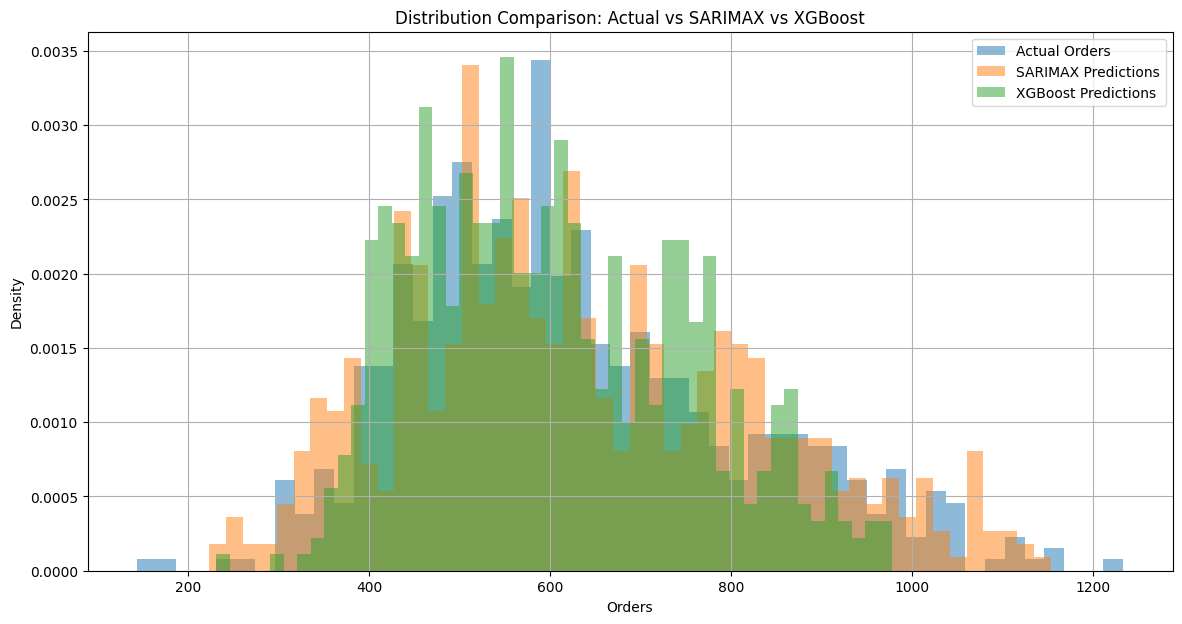

In [40]:
# --- Plot Actual vs SARIMAX vs XGBoost Distributions ---
plt.figure(figsize=(14, 7))

# Actual orders distribution
plt.hist(sarimax_actuals_untransformed, bins=50, alpha=0.5, label='Actual Orders', density=True)

# SARIMAX predictions distribution
plt.hist(sarimax_predictions_untransformed, bins=50, alpha=0.5, label='SARIMAX Predictions', density=True)

# XGBoost predictions distribution
plt.hist(xgboost_predictions, bins=50, alpha=0.5, label='XGBoost Predictions', density=True)

# Plot settings
plt.title('Distribution Comparison: Actual vs SARIMAX vs XGBoost')
plt.xlabel('Orders')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

Both `SARIMAX` and `XGBoost` predictions closely match the overall distribution of actual orders, but SARIMAX captures the extreme order values (tails) better than XGBoost.

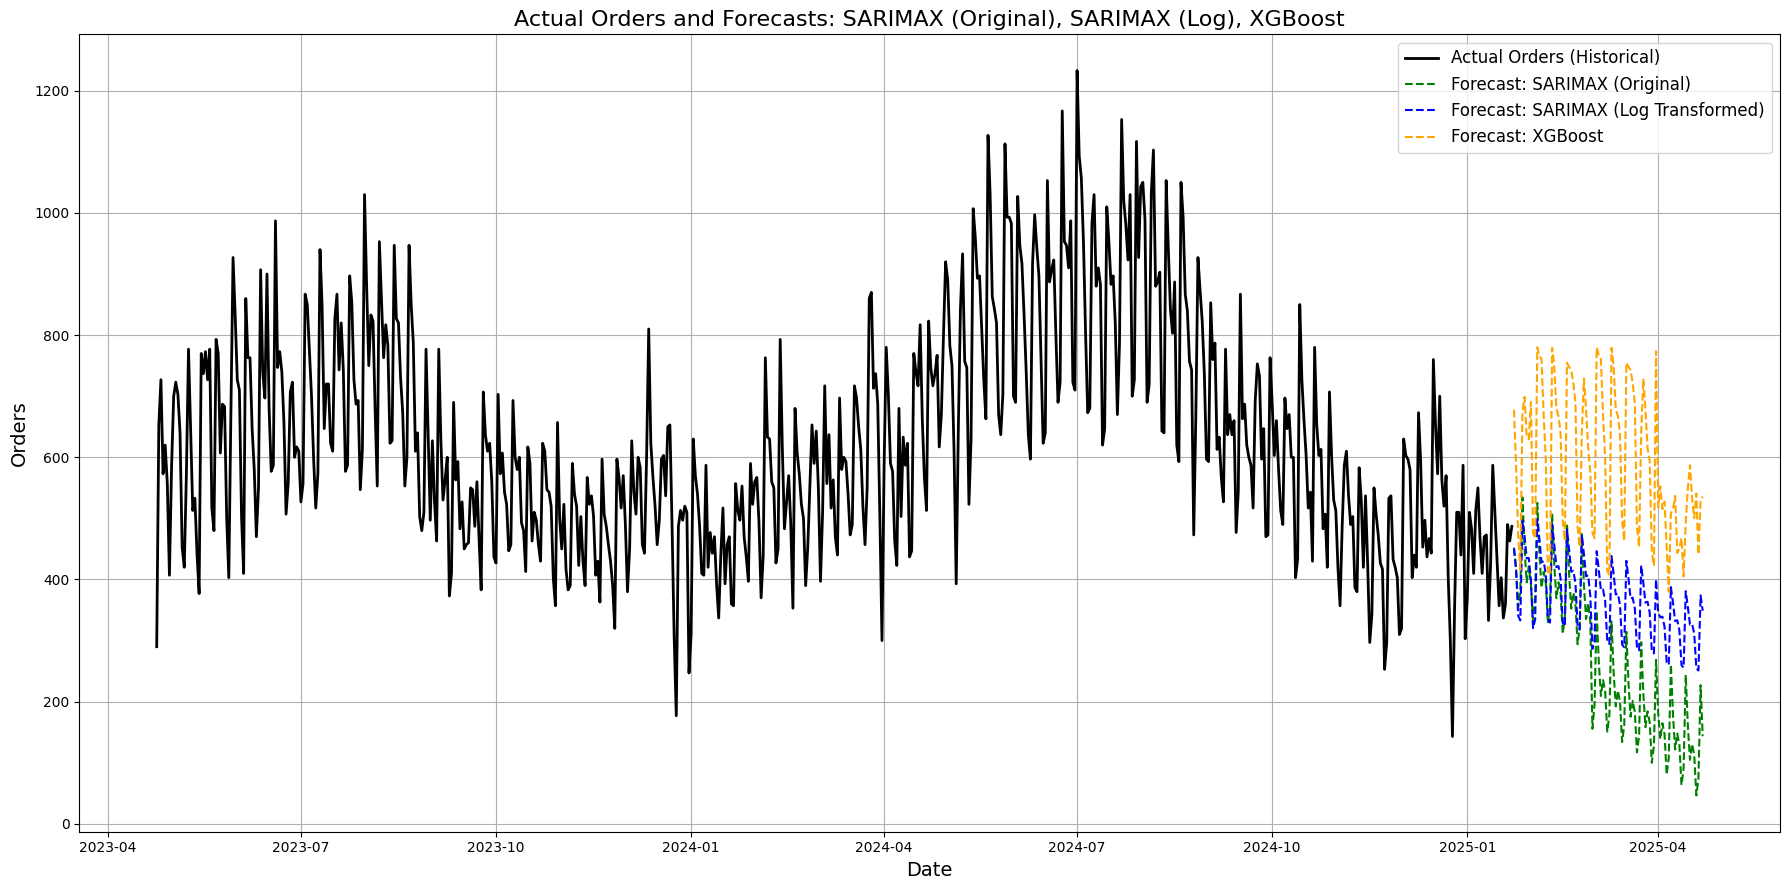

In [41]:
# --- Prepare Future Features ---

# Extract future dates
future_dates = sales_forecast.index

# Feature engineer future data
columns, future_features = feature_engineer(sales_forecast)

# Align columns (match training features)
missing_cols = set(X.columns) - set(future_features.columns)
for col in missing_cols:
    future_features[col] = 0.0
future_features = future_features[X.columns]  # Match column order

# --- Forecast From All Models ---

# SARIMAX (Original)
sarimax_forecast_untransformed = best_model_untransformed.get_forecast(
    steps=len(future_dates),
    exog=future_features
).predicted_mean

# SARIMAX (Log Transformed)
sarimax_forecast_log = best_model_log.get_forecast(
    steps=len(future_dates),
    exog=future_features
).predicted_mean
sarimax_forecast_log = np.expm1(sarimax_forecast_log)  # Inverse log transformation

# Scale future features (only for XGBoost)
future_features_scaled = scalar.transform(future_features)

# XGBoost Forecast
xgboost_forecast = best_model_xg.predict(future_features_scaled)

# --- Prepare Past Data (Historical Orders) ---

past_dates = sales_df.index
past_orders = sales_df['orders']

# --- Plot Historical and Future Forecasts ---

plt.figure(figsize=(18, 9))

# Plot actual historical sales
plt.plot(past_dates, past_orders, label='Actual Orders (Historical)', color='black', linewidth=2)

# Plot forecasts
plt.plot(future_dates, sarimax_forecast_untransformed.values, label='Forecast: SARIMAX (Original)', linestyle='--', color='green')
plt.plot(future_dates, sarimax_forecast_log.values, label='Forecast: SARIMAX (Log Transformed)', linestyle='--', color='blue')
plt.plot(future_dates, xgboost_forecast, label='Forecast: XGBoost', linestyle='--', color='orange')

# Plot settings
plt.title('Actual Orders and Forecasts: SARIMAX (Original), SARIMAX (Log), XGBoost', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Orders', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

*   SARIMAX worked better during cross-validation but struggled on truly unseen future data.
*   XGBoost captured sharp changes and performed better on real test data.
*   Recommend using XGBoost for production forecasting.

# Save Models and Pipeline (for Production)

In [42]:
import joblib

# Save StandardScaler
joblib.dump(scalar, 'scaler_xgboost.pkl')

# Save Best SARIMAX (Original)
joblib.dump(best_model_untransformed, 'best_model_sarimax_untransformed.pkl')

# Save Best SARIMAX (Log Transformed)
joblib.dump(best_model_log, 'best_model_sarimax_log.pkl')

# Save Best XGBoost
joblib.dump(best_model_xg, 'best_model_xgboost.pkl')

['best_model_xgboost.pkl']